In [ ]:
import numpy as np 
import pandas as pd
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from  keras.preprocessing.sequence import pad_sequences
from keras.models import *
from keras.layers import *
from keras.losses import *
from keras.callbacks import *
from keras.optimizers import *
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

df = pd.read_csv('/content/drive/MyDrive/data/train.csv')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
#Number of sentences
sentence_split = re.compile("[.!?'\";]")
df['num_sentences'] = df['text'].apply(lambda x: len(sentence_split.split(x)))
df['num_sentences'].describe()

count    54879.000000
mean         5.158622
std          4.023919
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max         79.000000
Name: num_sentences, dtype: float64

In [ ]:
# Number of words
df['num_words'] = df['text'].apply(lambda x: len(x.split(' ')))
df['num_words'].describe()

count    54879.000000
mean        42.257184
std         50.811812
min          5.000000
25%         12.000000
50%         22.000000
75%         50.000000
max        472.000000
Name: num_words, dtype: float64

In [ ]:
labelEncoder = LabelEncoder().fit(df['author'])
df['author_id'] = labelEncoder.transform(df['author'])

def gen_ngram(tokens, n):
    length = len(tokens)
    for i in range(2, n+1):
        for j in range(0, length+1-i):
            tokens.append('+'.join(tokens[j:j+i]))
    return tokens
    
def preprocess_text(text, stem_func=None, stop_words=set()):
    text = nltk.tokenize.word_tokenize(text)
    text = [w for w in text if not w in stop_words]
    if stem_func!=None:
        text = [stem_func(w) for w in text]
    return ' '.join(text)
wnl = nltk.stem.wordnet.WordNetLemmatizer()

df['text_proc'] = df['text'].apply(lambda x: preprocess_text(x, wnl.lemmatize, set()))
df['pos_tags'] = df['text_proc'].apply(lambda x: ' '.join([y[1] for y in nltk.pos_tag(x.split(' '))]))
df['text_proc'].head().apply(lambda x: len(x.split(' ')))
df['pos_tags'].head().apply(lambda x: len(x.split(' ')))
df.head()

,index,text,author,num_sentences,num_words,author_id,text_proc,pos_tags
0,0,"He was almost choking. There was so much, so m...",3,5,46,3,"He wa almost choking . There wa so much , so m...","PRP VBZ RB NN . EX VBZ RB JJ , RB RB PRP VBD T..."
1,1,"“Your sister asked for it, I suppose?”",2,2,7,2,"“ Your sister asked for it , I suppose ? ”","VB PRP$ NN VBD IN PRP , PRP VBP . NN"
2,2,"She was engaged one day as she walked, in per...",1,3,58,1,"She wa engaged one day a she walked , in perus...","PRP VBD JJ CD NN DT PRP VBD , IN VBG NNP NNP V..."
3,3,"The captain was in the porch, keeping himself ...",4,10,58,4,"The captain wa in the porch , keeping himself ...","DT NN NN IN DT NN , VBG PRP RB IN IN DT NN IN ..."
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3,10,39,3,"“ Have mercy , gentleman ! ” odin flung up his...","NNS VBP VBN , NN . JJ NN VBD RP PRP$ NN . JJ N..."


In [ ]:
# 세번째 모델 토큰화

tokenizer_text = Tokenizer(filters='', lower=False, split=' ')
tokenizer_text.fit_on_texts(df['text_proc'])
tokenizer_pos = Tokenizer(filters='', lower=False, split=' ')
tokenizer_pos.fit_on_texts(df['pos_tags'])

y = df['author_id'].values

X_text = tokenizer_text.texts_to_sequences(df['text_proc'])
X_text = pad_sequences(X_text)
X_pos = tokenizer_pos.texts_to_sequences(df['pos_tags'])
X_pos = pad_sequences(X_pos)

X_text_train, X_text_validation, X_pos_train, X_pos_validation, y_train, y_validation = train_test_split(X_text, X_pos, y, test_size=0.1)

In [ ]:
# 세번째 모델 3-2
import tensorflow as tf

pos_input = Input(shape=(X_pos.shape[1],), name='pos_input')
pos_embd = Embedding(input_dim=np.max(X_pos)+1, output_dim=10, input_length=X_pos.shape[1])(pos_input)

text_input = Input(shape=(X_text.shape[1],), name='text_input')
text_embd = Embedding(input_dim=np.max(X_text)+1, output_dim=10, input_length=X_text.shape[1])(text_input)

################## 모델링 ####################

x = concatenate([pos_embd, text_embd], axis=-1)
x1 = Conv1D(20, kernel_size=2, padding='same', activation='relu')(x)
x1 = GlobalMaxPooling1D()(x1)

x2 = Conv1D(20, kernel_size=2, padding='same', activation='relu')(x)
x2 = GlobalMaxPooling1D()(x2)

x3 = Conv1D(20, kernel_size=2, padding='same', activation='relu')(x)
x3 = GlobalMaxPooling1D()(x3)

x4 = Conv1D(20, kernel_size=2, padding='same', activation='relu')(x)
x4 = GlobalMaxPooling1D()(x4)

x = concatenate([x1,x2,x3,x4], axis=-1)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)

model_combined = Model(inputs = [text_input, pos_input], outputs=x)
model_combined.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pos_input (InputLayer)          [(None, 529)]        0                                            
__________________________________________________________________________________________________
text_input (InputLayer)         [(None, 529)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 529, 10)      460         pos_input[0][0]                  
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 529, 10)      448070      text_input[0][0]                 
____________________________________________________________________________________________

In [ ]:
model_combined.compile(optimizer = tf.keras.optimizers.Adam(),
               loss = 'sparse_categorical_crossentropy',
               metrics = ['accuracy'])

epochs=100

history = model_combined.fit({'pos_input':X_pos_train, 'text_input':X_text_train}, y_train, 
          epochs=epochs, 
          validation_data=({'pos_input':X_pos_validation, 'text_input':X_text_validation}, y_validation),
          callbacks=[EarlyStopping(patience=2, monitor='val_loss')],
          verbose=2)

Epoch 1/100
1544/1544 - 25s - loss: 1.1927 - accuracy: 0.5223 - val_loss: 0.8874 - val_accuracy: 0.6806
Epoch 2/100
1544/1544 - 24s - loss: 0.8216 - accuracy: 0.6962 - val_loss: 0.6849 - val_accuracy: 0.7505
Epoch 3/100
1544/1544 - 23s - loss: 0.6582 - accuracy: 0.7599 - val_loss: 0.6222 - val_accuracy: 0.7782
Epoch 4/100
1544/1544 - 23s - loss: 0.5682 - accuracy: 0.7960 - val_loss: 0.5967 - val_accuracy: 0.7779
Epoch 5/100
1544/1544 - 23s - loss: 0.4981 - accuracy: 0.8222 - val_loss: 0.5913 - val_accuracy: 0.7890
Epoch 6/100
1544/1544 - 24s - loss: 0.4568 - accuracy: 0.8375 - val_loss: 0.5985 - val_accuracy: 0.7832
Epoch 7/100
1544/1544 - 23s - loss: 0.4165 - accuracy: 0.8515 - val_loss: 0.6062 - val_accuracy: 0.7879


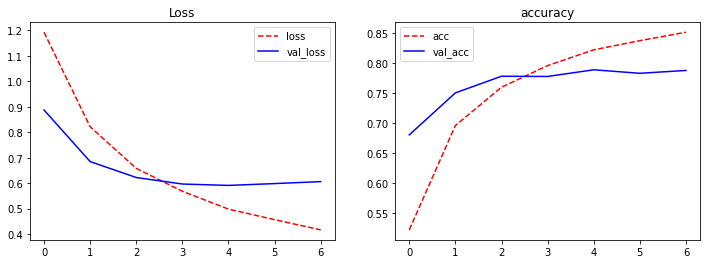

In [ ]:
# 세번째 모델 plot

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(history.history['loss'], 'r--', label = 'loss')
plt.plot(history.history['val_loss'], 'b-', label = 'val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.title("accuracy")
plt.plot(history.history['accuracy'], 'r--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'b-', label = 'val_acc')
plt.legend()

In [ ]:
# 세번째 모델 3-3
import tensorflow as tf

pos_input = Input(shape=(X_pos.shape[1],), name='pos_input')
pos_embd = Embedding(input_dim=np.max(X_pos)+1, output_dim=10, input_length=X_pos.shape[1])(pos_input)

text_input = Input(shape=(X_text.shape[1],), name='text_input')
text_embd = Embedding(input_dim=np.max(X_text)+1, output_dim=10, input_length=X_text.shape[1])(text_input)

################## 모델링 ####################

x = concatenate([pos_embd, text_embd], axis=-1)
x1 = Conv1D(20, kernel_size=2, padding='valid', activation='relu')(x)
x1 = GlobalMaxPooling1D()(x1)
x1 = Dropout(0.5)(x1)

x2 = Conv1D(20, kernel_size=2, padding='valid', activation='relu')(x)
x2 = GlobalMaxPooling1D()(x2)
x2 = Dropout(0.5)(x2)

x3 = Conv1D(20, kernel_size=2, padding='valid', activation='relu')(x)
x3 = GlobalMaxPooling1D()(x3)
x3 = Dropout(0.5)(x3)

x4 = Conv1D(20, kernel_size=2, padding='valid', activation='relu')(x)
x4 = GlobalMaxPooling1D()(x4)
x4 = Dropout(0.5)(x4)

x = concatenate([x1,x2,x3,x4], axis=-1)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)

model_combined = Model(inputs = [text_input, pos_input], outputs=x)
model_combined.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pos_input (InputLayer)          [(None, 529)]        0                                            
__________________________________________________________________________________________________
text_input (InputLayer)         [(None, 529)]        0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 529, 10)      460         pos_input[0][0]                  
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 529, 10)      448070      text_input[0][0]                 
____________________________________________________________________________________________

In [ ]:
model_combined.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

epochs=100

history = model_combined.fit({'pos_input':X_pos_train, 'text_input':X_text_train}, y_train, 
          epochs=epochs, 
          validation_data=({'pos_input':X_pos_validation, 'text_input':X_text_validation}, y_validation),
          callbacks=[EarlyStopping(patience=2, monitor='val_loss')],
          verbose=2)

Epoch 1/100
1544/1544 - 25s - loss: 1.3239 - accuracy: 0.4588 - val_loss: 1.0420 - val_accuracy: 0.6194
Epoch 2/100
1544/1544 - 23s - loss: 1.0203 - accuracy: 0.6105 - val_loss: 0.8196 - val_accuracy: 0.7110
Epoch 3/100
1544/1544 - 23s - loss: 0.8630 - accuracy: 0.6781 - val_loss: 0.7350 - val_accuracy: 0.7363
Epoch 4/100
1544/1544 - 23s - loss: 0.7739 - accuracy: 0.7126 - val_loss: 0.6982 - val_accuracy: 0.7518
Epoch 5/100
1544/1544 - 23s - loss: 0.7184 - accuracy: 0.7361 - val_loss: 0.6824 - val_accuracy: 0.7540
Epoch 6/100
1544/1544 - 23s - loss: 0.6731 - accuracy: 0.7527 - val_loss: 0.6668 - val_accuracy: 0.7651
Epoch 7/100
1544/1544 - 23s - loss: 0.6390 - accuracy: 0.7632 - val_loss: 0.6660 - val_accuracy: 0.7620
Epoch 8/100
1544/1544 - 23s - loss: 0.6118 - accuracy: 0.7756 - val_loss: 0.6791 - val_accuracy: 0.7553
Epoch 9/100
1544/1544 - 23s - loss: 0.5915 - accuracy: 0.7842 - val_loss: 0.6725 - val_accuracy: 0.7631


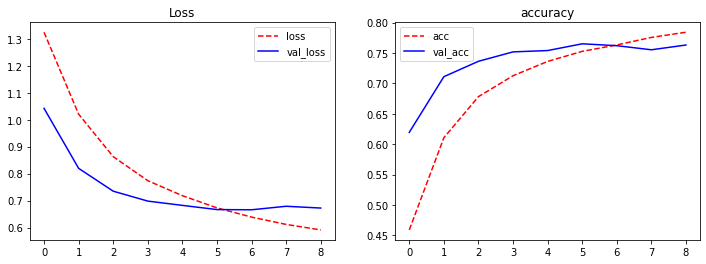

In [ ]:
# 세번째 모델 plot

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(history.history['loss'], 'r--', label = 'loss')
plt.plot(history.history['val_loss'], 'b-', label = 'val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.title("accuracy")
plt.plot(history.history['accuracy'], 'r--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'b-', label = 'val_acc')
plt.legend()

In [ ]:
# 세번째 모델 3-4
import tensorflow as tf

pos_input = Input(shape=(X_pos.shape[1],), name='pos_input')
pos_embd = Embedding(input_dim=np.max(X_pos)+1, output_dim=10, input_length=X_pos.shape[1])(pos_input)

text_input = Input(shape=(X_text.shape[1],), name='text_input')
text_embd = Embedding(input_dim=np.max(X_text)+1, output_dim=10, input_length=X_text.shape[1])(text_input)

################## 모델링 ####################

x = concatenate([pos_embd, text_embd], axis=-1)
x1 = Conv1D(20, kernel_size=2, padding='valid', activation='relu')(x)
x1 = GlobalMaxPooling1D()(x1)
x1 = Dropout(0.3)(x1)

x2 = Conv1D(20, kernel_size=2, padding='valid', activation='relu')(x)
x2 = GlobalMaxPooling1D()(x2)
x2 = Dropout(0.3)(x2)

x3 = Conv1D(20, kernel_size=3, padding='valid', activation='relu')(x)
x3 = GlobalMaxPooling1D()(x3)
x3 = Dropout(0.5)(x3)

x4 = Conv1D(20, kernel_size=3, padding='valid', activation='relu')(x)
x4 = GlobalMaxPooling1D()(x4)
x4 = Dropout(0.5)(x4)

x = concatenate([x1,x2,x3,x4], axis=-1)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)

model_combined = Model(inputs = [text_input, pos_input], outputs=x)
model_combined.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pos_input (InputLayer)          [(None, 529)]        0                                            
__________________________________________________________________________________________________
text_input (InputLayer)         [(None, 529)]        0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 529, 10)      460         pos_input[0][0]                  
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 529, 10)      448070      text_input[0][0]                 
___________________________________________________________________________________________

In [ ]:
model_combined.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

epochs=100

history = model_combined.fit({'pos_input':X_pos_train, 'text_input':X_text_train}, y_train, 
          epochs=epochs, 
          validation_data=({'pos_input':X_pos_validation, 'text_input':X_text_validation}, y_validation),
          callbacks=[EarlyStopping(patience=2, monitor='val_loss')],
          verbose=2)

Epoch 1/100
1544/1544 - 24s - loss: 1.2837 - accuracy: 0.4750 - val_loss: 0.9932 - val_accuracy: 0.6314
Epoch 2/100
1544/1544 - 23s - loss: 0.9555 - accuracy: 0.6361 - val_loss: 0.8059 - val_accuracy: 0.7090
Epoch 3/100
1544/1544 - 23s - loss: 0.8099 - accuracy: 0.6989 - val_loss: 0.7150 - val_accuracy: 0.7442
Epoch 4/100
1544/1544 - 23s - loss: 0.7201 - accuracy: 0.7366 - val_loss: 0.6842 - val_accuracy: 0.7480
Epoch 5/100
1544/1544 - 22s - loss: 0.6564 - accuracy: 0.7602 - val_loss: 0.6608 - val_accuracy: 0.7591
Epoch 6/100
1544/1544 - 23s - loss: 0.6068 - accuracy: 0.7805 - val_loss: 0.6525 - val_accuracy: 0.7635
Epoch 7/100
1544/1544 - 23s - loss: 0.5762 - accuracy: 0.7910 - val_loss: 0.6454 - val_accuracy: 0.7720
Epoch 8/100
1544/1544 - 23s - loss: 0.5397 - accuracy: 0.8041 - val_loss: 0.6516 - val_accuracy: 0.7699
Epoch 9/100
1544/1544 - 23s - loss: 0.5148 - accuracy: 0.8126 - val_loss: 0.6509 - val_accuracy: 0.7706


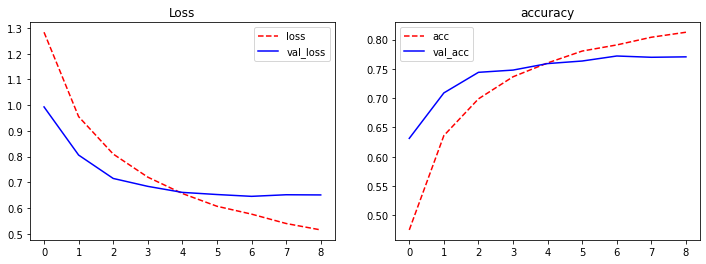

In [ ]:
# 세번째 모델 plot

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(history.history['loss'], 'r--', label = 'loss')
plt.plot(history.history['val_loss'], 'b-', label = 'val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.title("accuracy")
plt.plot(history.history['accuracy'], 'r--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'b-', label = 'val_acc')
plt.legend()

In [ ]:
# 세번째 모델 3-4
import tensorflow as tf

pos_input = Input(shape=(X_pos.shape[1],), name='pos_input')
pos_embd = Embedding(input_dim=np.max(X_pos)+1, output_dim=10, input_length=X_pos.shape[1])(pos_input)

text_input = Input(shape=(X_text.shape[1],), name='text_input')
text_embd = Embedding(input_dim=np.max(X_text)+1, output_dim=10, input_length=X_text.shape[1])(text_input)

################## 모델링 ####################

x = concatenate([pos_embd, text_embd], axis=-1)
x1 = Conv1D(20, kernel_size=2, padding='valid', activation='relu')(x)
x1 = GlobalMaxPooling1D()(x1)
x1 = Dropout(0.3)(x1)

x2 = Conv1D(20, kernel_size=2, padding='valid', activation='relu')(x)
x2 = GlobalMaxPooling1D()(x2)
x2 = Dropout(0.3)(x2)

x3 = Conv1D(20, kernel_size=2, padding='valid', activation='relu')(x)
x3 = GlobalMaxPooling1D()(x3)
x3 = Dropout(0.5)(x3)

x4 = Conv1D(20, kernel_size=3, padding='valid', activation='relu')(x)
x4 = GlobalMaxPooling1D()(x4)
x4 = Dropout(0.5)(x4)

x = concatenate([x1,x2,x3,x4], axis=-1)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)

model_combined = Model(inputs = [text_input, pos_input], outputs=x)
model_combined.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pos_input (InputLayer)          [(None, 529)]        0                                            
__________________________________________________________________________________________________
text_input (InputLayer)         [(None, 529)]        0                                            
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 529, 10)      460         pos_input[0][0]                  
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 529, 10)      448070      text_input[0][0]                 
___________________________________________________________________________________________

In [ ]:
model_combined.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

epochs=100

history = model_combined.fit({'pos_input':X_pos_train, 'text_input':X_text_train}, y_train, 
          epochs=epochs, 
          validation_data=({'pos_input':X_pos_validation, 'text_input':X_text_validation}, y_validation),
          callbacks=[EarlyStopping(patience=2, monitor='val_loss')],
          verbose=2)

Epoch 1/100
1544/1544 - 24s - loss: 1.2971 - accuracy: 0.4663 - val_loss: 0.9912 - val_accuracy: 0.6368
Epoch 2/100
1544/1544 - 23s - loss: 0.9739 - accuracy: 0.6294 - val_loss: 0.7983 - val_accuracy: 0.7157
Epoch 3/100
1544/1544 - 23s - loss: 0.8199 - accuracy: 0.6948 - val_loss: 0.6989 - val_accuracy: 0.7495
Epoch 4/100
1544/1544 - 23s - loss: 0.7295 - accuracy: 0.7323 - val_loss: 0.6626 - val_accuracy: 0.7629
Epoch 5/100
1544/1544 - 23s - loss: 0.6675 - accuracy: 0.7559 - val_loss: 0.6417 - val_accuracy: 0.7653
Epoch 6/100
1544/1544 - 23s - loss: 0.6167 - accuracy: 0.7740 - val_loss: 0.6297 - val_accuracy: 0.7720
Epoch 7/100
1544/1544 - 23s - loss: 0.5789 - accuracy: 0.7874 - val_loss: 0.6316 - val_accuracy: 0.7751
Epoch 8/100
1544/1544 - 23s - loss: 0.5492 - accuracy: 0.7978 - val_loss: 0.6319 - val_accuracy: 0.7741


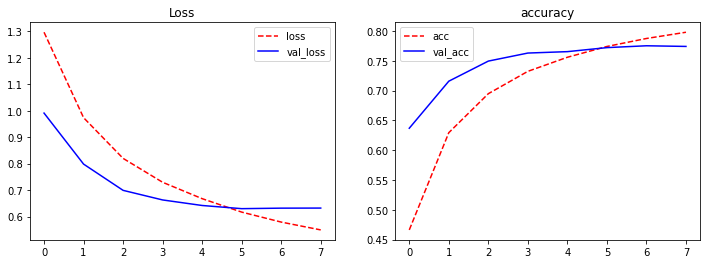

In [ ]:
# 세번째 모델 plot

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(history.history['loss'], 'r--', label = 'loss')
plt.plot(history.history['val_loss'], 'b-', label = 'val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.title("accuracy")
plt.plot(history.history['accuracy'], 'r--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'b-', label = 'val_acc')
plt.legend()